# Section 1

## Efstathios Galanakis 03112172
## Ioannis Tzanettis 03112506
## Team Number: 83


Datasheet Name: Sonar (Number S3)
Number of features: 60
Number of classes: 2 (Mine, Rock)


# Insert Dataset
This datasheet contains data taken from a sonar signal.

Taking into account the file sonar.name, which gives us information about the datasheet, there aren't any
headers or numbering so when we use the read__csv command, we will add the option header=None. The label of
each sample is placed at the last column.

We use, as we previously said, the command read_csv in order to read the datasheet from the file
sonar.all-data. No changes to the file or the datasheet are needed.

The file sonar.names doesn't refer to any missing data so we supposed that there aren't. It says that 
every feature's value range is between 0.0 and 1.0.

We need to convert labels string values to int values so we are going to create the following mapping:
mapping = {'R' : 0, 'M' : 1}

We have to check if the sample data are unbalanced in case they aren't, to resample them.

In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

features = []
labels = []


datasheet_path='./small/sonar.all-data'
datasheet = pd.read_csv(datasheet_path, header=None)

labels = datasheet.iloc[:, [-1]]
features = datasheet.iloc[:, 0 :-1].values

mapping = {'R' : 0, 'M' : 1}
labels = labels.replace(mapping).values.flatten()
print datasheet.shape
print features.shape, labels.shape

# check labels freqs
label_freq = np.bincount(labels)/np.float64(labels.size)
max_rate = np.max(label_freq)

ros = RandomOverSampler(random_state=0)

if (max_rate > 0.6):
    print "resampling..."
    features, labels = ros.fit_sample(features,labels)

print max_rate


(208, 61)
(208, 60) (208,)
0.533653846154


Test data is 20% of the total data and the rest 80% is consider as train data.

In [94]:
perc = 0.2

x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=perc,random_state=0)

print  features.shape, labels.shape
print x_train.shape, x_test.shape, y_train.shape, y_test.shape


(208, 60) (208,)
(166, 60) (42, 60) (166,) (42,)


# Baseline classification
After spliting the data, it's time to create the dummy classifiers and the MLP classifier with
default parameters, in order to compare with their improved versions. For the constant strategy,
we will predict M for every state which means we have a Mine there.

In [95]:
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


state = 1
dummy_strategies = [ 'stratified', 'most_frequent', 'prior', 'uniform', 'constant']
conf = []
macro = []
weighted = []
precision = []
recall = []
time_array = []
# dummy_classifiers= {}
for i in dummy_strategies:
    if (i == 'constant'):
        dummy_classifiers=DummyClassifier(strategy=i, constant=state)
    else:
        dummy_classifiers=DummyClassifier(strategy=i)

    start_time = time.time()
    dummy_classifiers.fit(x_train,y_train)
    time_array += [time.time() - start_time]

    results = dummy_classifiers.predict(x_test)
    conf.append( confusion_matrix(y_test, results))
    macro += [f1_score(y_test, results, average='macro')]
    weighted.append(  f1_score(y_test, results, average='weighted'))
    precision.append( precision_score(y_test, results))
    recall.append(  recall_score(y_test, results))
    print dummy_classifiers.strategy, ":", accuracy_score(results,y_test)
    
default_clf_Mlp = MLPClassifier();

start_time = time.time()    
default_clf_Mlp.fit(x_train, y_train)
time_array += [ time.time() - start_time]
results = default_clf_Mlp.predict(x_test)
conf.append( confusion_matrix(y_test, results))
macro.append( f1_score(y_test, results, average='macro'))
weighted.append(f1_score(y_test, results, average='weighted'))
precision.append(  precision_score(y_test, results))
recall.append(recall_score(y_test, results))
print "default_clf_Mlp :",accuracy_score(results,y_test)
print time_array

stratified : 0.47619047619
most_frequent : 0.5
prior : 0.5
uniform : 0.547619047619
constant : 0.5
default_clf_Mlp : 0.880952380952
[0.00041604042053222656, 0.00019693374633789062, 0.00022482872009277344, 0.0002410411834716797, 0.0002968311309814453, 0.3537721633911133]


Metrics Plots

['stratified', 'most_frequent', 'prior', 'uniform', 'constant', 'MLP']


<Container object of 6 artists>

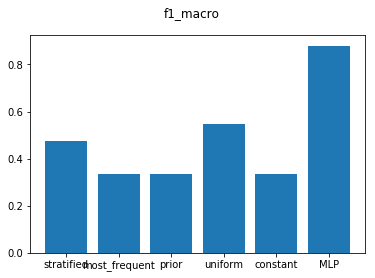

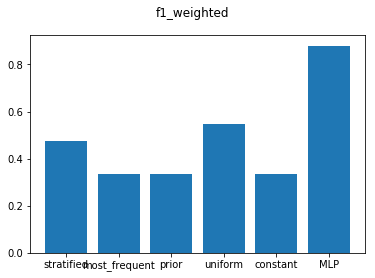

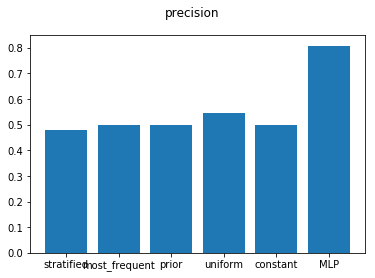

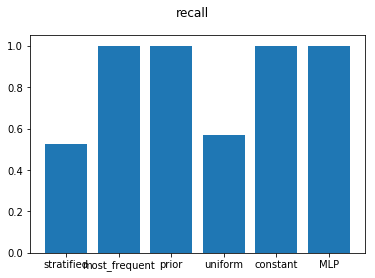

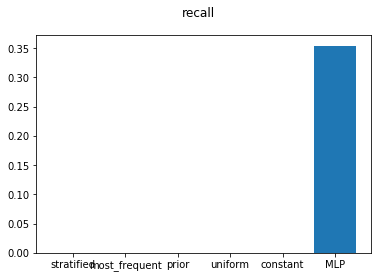

In [96]:
import matplotlib.pyplot as plt
clf_names = dummy_strategies + ['MLP']
print clf_names
fig = 1
plt.figure(fig)
plt.suptitle('f1_macro')
plt.bar(range(len(macro)),macro,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('f1_weighted')
plt.bar(range(len(weighted)),weighted,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('precision')
plt.bar(range(len(precision)),precision,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('recall')
plt.bar(range(len(recall)),recall,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('recall')
plt.bar(range(len(time_array)),time_array,tick_label=clf_names)



# Classifier Optimization
## Feature selection

Now it's time to create our improved MLP classifier. First we create a VarianceThreshold selector with threshold 5%
in order to reduce the number of features. Then we use a mask (selected_features) in order to keep the selected features.

In [97]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.0001)
reduced_train_data = selector.fit_transform(x_train)

print reduced_train_data.shape

selected_features = selector.get_support()
reduced_test_data = x_test[:,selected_features]

print reduced_test_data.shape

(166, 51)
(42, 51)


## Scaling features
We need to scale our data, in order to take values in the range [-1, 1]. So we need to
check if exists any value bigger than 1.0 or smaller than -1. If there is no such value, no scalling
is needed.

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(reduced_train_data)
scaled_test_data =  scaler.fit_transform(reduced_test_data)

print scaled_train_data.shape

(166, 51)


## Resampling
We need to examine if our dataset is balanced, which means that there is no label, whose rate through the dataset
is 1.5 times more frequent than the rest of the labels.

In [99]:
from imblearn.over_sampling import RandomOverSampler

label_freq = np.bincount(y_train)/np.float64(y_train.size)
max_rate = np.max(label_freq)

ros = RandomOverSampler(random_state=0)

if (max_rate > 0.6):
    print "resampling..."
    scaled_train_data, y_train = ros.fit_sample(scaled_train_data,y_train)

print max_rate

0.542168674699


## Cross Validation
### Create a scorer
After data preprocessing, it's time to select the suitable MLP Classifier. We will break our train set into 10 sets
and we are going to use 2 metrics: f1_macro and f1_weighted, so we need to make a new scorer which sets the final
score as the sum of the previous metrics' score.

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

def my_scorer(estimator, x, y):
    prediction = estimator.predict(x)
    macro_score = f1_score(y, prediction, average='macro')
    weighted_score = f1_score(y, prediction, average='weighted')
    prec_score = presicion_score(y, prediction)
    rec_score = recall_score(y, prediction)
    return macro_score + weighted_score + prec_score + rec_score
    
k = 10
scoring_policy = ['f1_macro', 'f1_weighted']


### Parameter estimation
Now it's time to estimate MLP Classifier parameters, using cross validation.
First we have to find the best solve.
We search for all the available options.
Because it takes too much time we put the excecuted code in comments and we
take for granted the optimal values.

In [101]:
hidden_layer_opts = range(120,170,20)
act_opts = ['identity', 'logistic', 'tanh', 'relu']
solver_opts = ['lbfgs', 'sgd', 'adam']
learn_opts = ['constant', 'invscaling', 'adaptive']
alpha_opt =  np.logspace(-5, 3, 5)

# best_score = 0
# best_params = []
# for tmp_hid_layer in hidden_layer_opts:
#     print tmp_hid_layer
#     for tmp_activation in act_opts:
#         for tmp_solver in solver_opts:
#             for tmp_learn in learn_opts:
#                 for tmp_alpha in alpha_opt:
#                     clf = MLPClassifier(warm_start=True,hidden_layer_sizes=tmp_hid_layer,activation=tmp_activation, 
#                     solver=tmp_solver, learning_rate=tmp_learn, alpha=tmp_alpha)
#                     # clf.fit(scaled_train_data,y_train)
#                     f_score= np.mean(cross_val_score(clf,scaled_train_data,y_train,cv=k,scoring= 'f1_weighted', n_jobs=-1))
#                     if (f_score > best_score):
#                         best_score = f_score
#                         best_params = [tmp_hid_layer,tmp_activation,tmp_solver,tmp_learn,tmp_alpha]
#                         print best_score
#                         print "best params:", best_params

# print best_score
# print "final best params:", best_params
    

We didn't take account the max_iter paramater, so for the optimal parameters we
want to find the optimal max number of iterations.

In [103]:
best_params= [140, 'relu', 'lbfgs', 'constant', 0.10000000000000001]

# best_score = 0
# best_iter = -1
# max_iter_opts = range(50, 460, 50)
# print max_iter_opts
# for i in max_iter_opts:
#     print i
#     clf = MLPClassifier(warm_start=True,hidden_layer_sizes=best_params[0],activation=best_params[1],
#                         solver=best_params[2],learning_rate=best_params[3],alpha=best_params[4],max_iter=i)
#     f_score= np.mean(cross_val_score(clf,scaled_train_data,y_train,cv=k,scoring= 'f1_weighted', n_jobs=-1))
#     if (f_score > best_score):
#         best_score = f_score
#         best_iter = i
#         print "max_iter:", best_iter, "score:", best_score

# print "final max_iter:", best_iter, "score:", best_score
                



After we've found the best hyperparameters, it's time to examine them using the previous metrics

In [104]:
best_params= [140, 'relu', 'lbfgs', 'constant', 0.10000000000000001, 250]


state = 1
dummy_strategies = [ 'stratified', 'most_frequent', 'prior', 'uniform', 'constant']
opt_conf = []
opt_macro = []
opt_weighted = []
opt_precision = []
opt_recall = []
opt_time_array = []
# dummy_classifiers= {}
for i in dummy_strategies:
    if (i == 'constant'):
        dummy_classifiers=DummyClassifier(strategy=i, constant=state)
    else:
        dummy_classifiers=DummyClassifier(strategy=i)


    start_time = time.time()
    dummy_classifiers.fit(scaled_train_data,y_train)
    opt_time_array += [time.time() - start_time]

    results = dummy_classifiers.predict(scaled_test_data)
    opt_conf.append( confusion_matrix(y_test, results))
    opt_macro += [f1_score(y_test, results, average='macro')]
    opt_weighted.append(  f1_score(y_test, results, average='weighted'))
    opt_precision.append( precision_score(y_test, results))
    opt_recall.append(  recall_score(y_test, results))
    print dummy_classifiers.strategy, ":", accuracy_score(results,y_test)


clf = MLPClassifier(warm_start=True,hidden_layer_sizes=best_params[0],activation=best_params[1],
                    solver=best_params[2],learning_rate=best_params[3],alpha=best_params[4],max_iter=best_params[5])

start_time = time.time()    
clf.fit(scaled_train_data,y_train)
opt_time_array += [time.time() - start_time]
results = clf.predict(scaled_test_data)
opt_conf.append( confusion_matrix(y_test, results))
opt_macro.append( f1_score(y_test, results, average='macro'))
opt_weighted.append(f1_score(y_test, results, average='weighted'))
opt_precision.append(  precision_score(y_test, results))
opt_recall.append(recall_score(y_test, results))
print "MLP :",accuracy_score(results,y_test)
print opt_time_array

stratified : 0.547619047619
most_frequent : 0.5
prior : 0.5
uniform : 0.571428571429
constant : 0.5
MLP : 0.904761904762
[0.0006089210510253906, 0.00020194053649902344, 0.00017905235290527344, 0.0001838207244873047, 0.0006260871887207031, 0.1649770736694336]


Time to plot our metrics

['stratified', 'most_frequent', 'prior', 'uniform', 'constant', 'MLP']


<Container object of 6 artists>

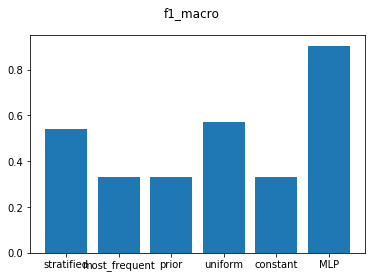

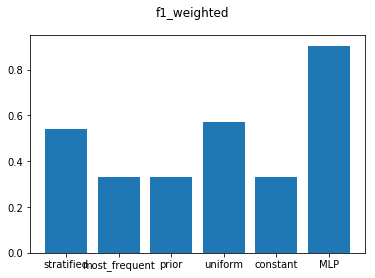

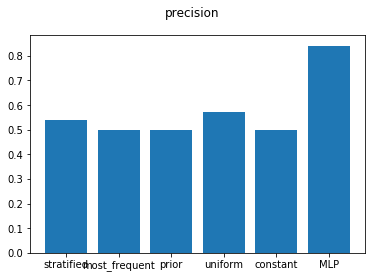

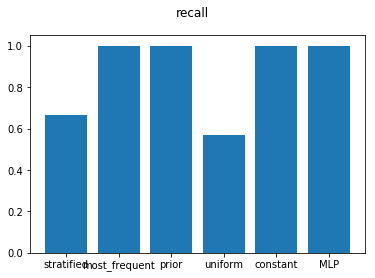

In [105]:
clf_names = dummy_strategies + ['MLP']
print clf_names
fig = 1
plt.figure(fig)
plt.suptitle('f1_macro')
plt.bar(range(len(opt_macro)),opt_macro,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('f1_weighted')
plt.bar(range(len(opt_weighted)),opt_weighted,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('precision')
plt.bar(range(len(opt_precision)),opt_precision,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('recall')
plt.bar(range(len(opt_recall)),opt_recall,tick_label=clf_names)

Time to compare our metrics

In [108]:
for i in range(0,len(clf_names)):
    print clf_names[i]
    print 
    print "unprocessed data:"
    print "f1_macro\t ==>\t",macro[i]
    print "f1_weighted\t ==>\t", weighted[i]
    print "precision\t ==> \t", precision[i]
    print "recall score\t ==> \t", recall[i]
    print "time spent\t ==> \t", time_array[i]
    print
    print "processed data:"
    print "f1_macro\t ==>\t",opt_macro[i]
    print "f1_weighted\t ==>\t", opt_weighted[i]
    print "precision\t ==> \t", opt_precision[i]
    print "recall score\t ==> \t", opt_recall[i]
    print "time spent\t ==> \t", opt_time_array[i]
    print
    print "change rate (%):"
    print "f1_macro\t ==>\t",-(macro[i]-opt_macro[i])/macro[i]*100
    print "f1_weighted\t ==>\t", -(weighted[i]- opt_weighted[i])/weighted[i]
    print "precision\t ==> \t", -(precision[i]-opt_precision[i])/precision[i]
    print "recall score\t ==> \t", -(recall[i]-opt_recall[i])/recall[i]
    print "time spent\t ==> \t", (time_array[i]-opt_time_array[i])/time_array[i]
    print

stratified

unprocessed data:
f1_macro	 ==>	0.475
f1_weighted	 ==>	0.475
precision	 ==> 	0.478260869565
recall score	 ==> 	0.52380952381
time spent	 ==> 	0.000416040420532

processed data:
f1_macro	 ==>	0.541115583669
f1_weighted	 ==>	0.541115583669
precision	 ==> 	0.538461538462
recall score	 ==> 	0.666666666667
time spent	 ==> 	0.000608921051025

change rate (%):
f1_macro	 ==>	13.9190702461
f1_weighted	 ==>	0.139190702461
precision	 ==> 	0.125874125874
recall score	 ==> 	0.272727272727
time spent	 ==> 	-0.463610315186

most_frequent

unprocessed data:
f1_macro	 ==>	0.333333333333
f1_weighted	 ==>	0.333333333333
precision	 ==> 	0.5
recall score	 ==> 	1.0
time spent	 ==> 	0.000196933746338

processed data:
f1_macro	 ==>	0.333333333333
f1_weighted	 ==>	0.333333333333
precision	 ==> 	0.5
recall score	 ==> 	1.0
time spent	 ==> 	0.000201940536499

change rate (%):
f1_macro	 ==>	-0.0
f1_weighted	 ==>	-0.0
precision	 ==> 	-0.0
recall score	 ==> 	-0.0
time spent	 ==> 	-0.0254237288136

prior
